# Beispiel nichtlineares Randwertproblem

In [1]:
import numpy as np
from numpy.linalg import norm
from scipy.linalg import qr, solve_triangular
import matplotlib.pyplot as plt

## Gelfand-Gleichung

Als Beispiel für ein nichtlineares Randwertproblem betrachten wir die Gelfand-Gleichung im eindimensionalen auf dem Intervall $[-1,1]$, wird im 1d auch Bratu's Randwertproblem genannt:

$$\begin{split}
-u''(x) & = \lambda e^{u(x)}\\
u(-1) & = u(1) = 0.
\end{split}$$

Die Gleichung erscheint in der Thermodynamik im Zusammenhang mit explodierenden thermischen Reaktionen, in der Astrophysik z. B. als Emden-Chandrasekhar-Gleichung.

Für das Randwertproblem kann eine analytische Lösung berechnet werden

$$u(x) = \log \left(\frac{\theta \left(1-\tanh ^2\left(\sqrt{\frac{\theta}{2}}\ x\right)\right)}{\lambda }\right),$$

wobei $\theta = \theta(\lambda)$ Lösung der nichtlinearen Gleichung

$$\theta \left(1-\tanh ^2\left(\sqrt{\frac{\theta}{2}}\right)\right) = \lambda$$

ist.

In [2]:
def lamC1(theta):
    return theta*(1-np.tanh(np.sqrt(theta/2))**2)
def dlamC1(theta):
    sqt = np.sqrt(theta)
    sq2 = np.sqrt(2)
    return (2 - sq2*sqt*np.tanh(sqt/sq2))/(2*np.cosh(sqt/sq2)**2)

In [3]:
def computeTheta(lam, theta0=0):
    n=10
    tol = 1e-15
    k = 0
    theta = theta0
    while np.abs(lamC1(theta)-lam) > tol and k < n:
        theta -= (lamC1(theta)-lam)/dlamC1(theta)
        k += 1
    if k == n:
        return -1
    else:
        return theta

In [4]:
def uanalytical(x, lam, theta0=1):
    theta = computeTheta(lam, theta0=theta0)
    return np.log((theta*(1 - np.tanh(x*np.sqrt(theta/2))**2))/lam)

Aus der Abbildung der Funktion $\theta(\lambda)$ folgt, dass nur für $\lambda\in[0,\lambda^*]$ Lösungen existieren. Weiter ist zu bemerken dass für $\lambda\in(0,\lambda^*)$ genau zwei Lösungen existieren. Wir bezeichnen die 1. Lösungen (blau) als *untere* und die 2. Lösungen (orange) als *obere Lösungen* (bzw. unterer / oberer Ast).

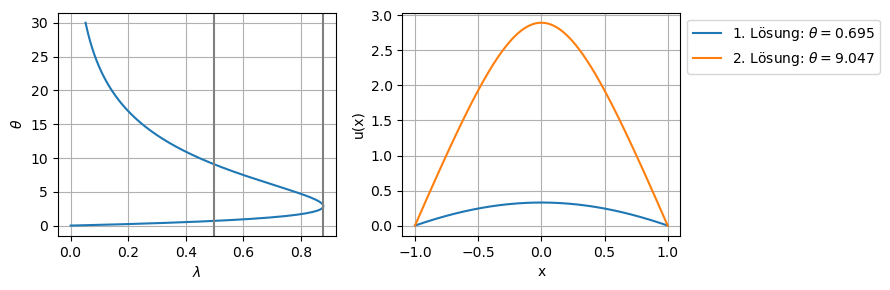

In [5]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
theta = np.linspace(0,30,300)
plt.plot(lamC1(theta),theta)
plt.axvline(0.8784576797812906,c='gray')
plt.axvline(0.5,c='gray')
plt.grid()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\theta$')
plt.subplot(1,2,2)
xp = np.linspace(-1,1,400)
plt.plot(xp, uanalytical(xp,0.5,1),label=r'1. Lösung: $\theta = $'+str(np.round(computeTheta(0.5, theta0=1),3)))
plt.plot(xp, uanalytical(xp,0.5,10),label=r'2. Lösung: $\theta = $'+str(np.round(computeTheta(0.5, theta0=10),3)))
plt.legend(bbox_to_anchor=(1,1))
plt.grid()
plt.xlabel('x')
plt.ylabel('u(x)')
plt.tight_layout()
#plt.savefig('loesungengelfand.pdf')
plt.show()

Wir diskretisieren das Problem mit Hilfe von finiten Differenzen. Dazu zerlegen wir das Intervall $[-1,1]$ wiederum in die Teilintervalle
$$[x_0, x_1], [x_1, x_2], \ldots, [x_{n-1}, x_n],$$
wobei $x_0 = -1 < x_1 < \ldots < x_{n-1} < x_n = 1$ gilt und schreiben
$$u_i = u(x_i) \quad \text{für}\ i = 0, \ldots, n.$$
Damit folgen die $n-1$ diskretisierten Gleichungen
\begin{equation}\begin{array}{rcl}\label{eq:fdmNonlin}
-u_{0} + 2\, u_1 - u_2 & = & h^2 \lambda\, e^{u_1}\\
& \vdots & \\
-u_{n-2} + 2\, u_{n-1} - u_n & = & h^2 \lambda\, e^{u_{n-1}}.
\end{array}\end{equation}

## Fixpunkt Iteration

Die diskrete Gleichung kann als Fixpunktgleichung geschrieben werden

$$\begin{split}u_1 & = \frac{1}{2} \left(u_{0} + u_{2} + h^2 \lambda\, e^{u_1}\right)\\
 \vdots \\
 u_{n-1} & = \frac{1}{2} \left(u_{n-2} + u_{n} + h^2 \lambda\, e^{u_{n-1}}\right)
\end{split}$$

und wir können versuchen Lösungen mit Hilfe einer Fixpunkt Iteration zu berechnen.

In [6]:
def f(u, lam, h):
    return 1/2*(u[:-2]+u[2:]+h**2*lam*(np.exp(u[1:-1])))

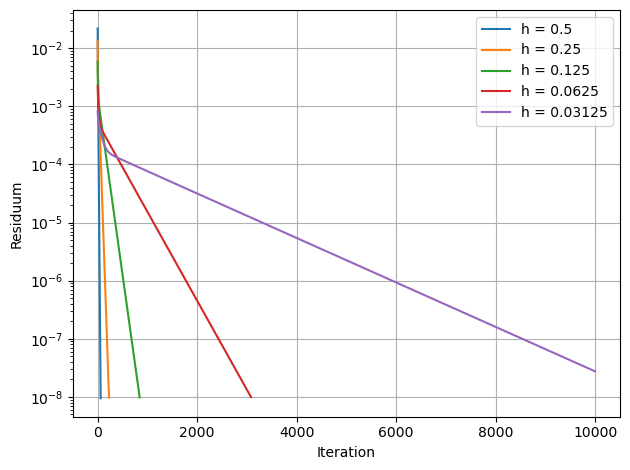

In [7]:
a = 1
lam = 1/2
sol = []
for n in 2**np.arange(2,7):#np.arange(6,12):
    x = np.linspace(-a,a,n+1)
    h = 2*a/n
    # Startwert
    u = .3*np.cos(x*np.pi/2)
    res = [norm(u[1:-1] - f(u,lam,h))]
    k = 0
    N = 1e4
    tol = 1e-8
    # Fixpunktiteration
    while k < N and res[-1] > tol:
        u[1:-1] = f(u,lam,h)
        res.append(norm(u[1:-1] - f(u,lam,h)))
        k += 1
    # Konvergenz
    plt.semilogy(res, label='h = '+str(h))
    sol.append(np.array([x,u]))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Residuum')
plt.grid()
plt.tight_layout()
#plt.savefig('gelfandKonvergenzFixpunkt.pdf')
plt.show()

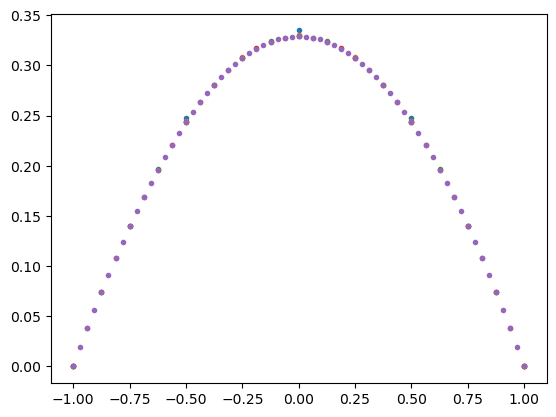

In [8]:
for s in sol:
    plt.plot(s[0],s[1],'.')
#plt.plot(x,uanalytical(x),'--')

## Newton Verfahren

Wir berechnen nun mit Hilfe des Newton-Verfahrens die numerische Lösung der Nullstellengleichung und definieren

$$\begin{split}
g : \mathbb{R}^{n-1} & \to \mathbb{R}^{n-1}\\
u & \mapsto g(u) = \begin{pmatrix}
-u_{0} + 2\, u_1 - u_2 - h^2 \lambda\, e^{u_1}\\
\vdots \\
-u_{n-2} + 2\, u_{n-1} - u_n - h^2 \lambda\, e^{u_{n-1}}\end{pmatrix}.
\end{split}$$

Die Randwerte $u_0,u_n$ sind gegeben. Daher gilt $u = (u_1, \ldots, u_{n-1})^T\in\mathbb{R}^{n-1}$.

In [9]:
def g(u,lam,h):
    return -u[:-2]+2*u[1:-1]-u[2:]-h**2*lam*(np.exp(u[1:-1]))

Jacobi-Matrix von $g$ bezüglich $u_1, \ldots, u_{n-1}$

$$\begin{split}
g' : \mathbb{R}^{n-1} & \to \mathbb{R}^{(n-1)\times(n-1)}\\
u & \mapsto g'(u) = \begin{pmatrix}
(2\, - h^2 \lambda\, e^{u_1}) & - 1 &  & 0\\
-1 & &  & \\
 & & \ddots &   \\
 &  &  & -1\\
0 &  & -1 & (2- h^2 \lambda\, e^{u_{n-1}})\end{pmatrix}.
\end{split}$$


In [10]:
def dg(u,lam,h):
    n = u.shape[0]-2
    a = -np.diag(np.ones(n-1),1)+np.diag(2*np.ones(n))-np.diag(np.ones(n-1),-1)
    a -= h**2*lam*np.diag(np.exp(u[1:-1]))
    return a

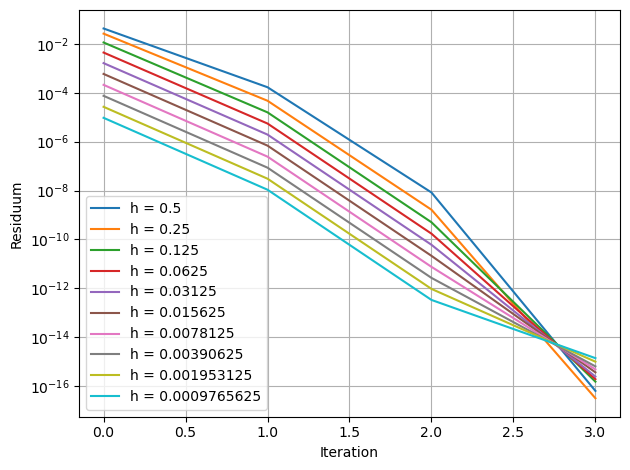

In [11]:
solN = []
for n in 2**np.arange(2,12):
    x = np.linspace(-a,a,n+1)
    h = 2*a/n
    # Initialisieren
    u = .3*np.cos(x*np.pi/2)
    res = [norm(g(u,lam,h))]
    k = 0
    N = 5
    tol = 1e-14
    # Newton Iteration
    while k < N and res[-1] > tol:
        b = g(u,lam,h)
        A = dg(u,lam,h)
        q,r = qr(A)
        delta = solve_triangular(r,q.T@b)
        u[1:-1] -= delta
        res.append(norm(g(u,lam,h)))
        k += 1
    plt.semilogy(res, label='h = '+str(h))
    solN.append(np.array([x,u]))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Residuum')
plt.grid()
plt.tight_layout()
plt.show()

Mit dem Startwert

$$u_0(x) = 0.3 \cos(\pi/2 x)$$

erhalten wir die Lösungen auf dem unteren Ast.

In [12]:
n = 2**4
x = np.linspace(-a,a,n+1)
h = 2*a/n
# Initialisieren
u = .3*np.cos(x*np.pi/2)
res = [norm(g(u,lam,h))]
k = 0
N = 5
tol = 1e-14
# Newton Iteration
while k < N and res[-1] > tol:
    b = g(u,lam,h)
    A = dg(u,lam,h)
    q,r = qr(A)
    delta = solve_triangular(r,q.T@b)
    u[1:-1] -= delta
    res.append(norm(g(u,lam,h)))
    k += 1
u1 = np.array(u)

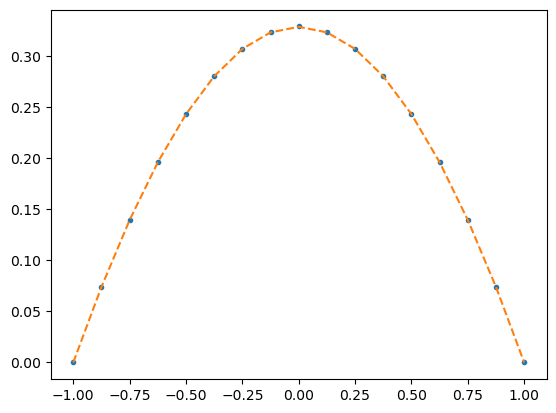

In [13]:
plt.plot(x,u1,'.')
plt.plot(x,uanalytical(x,0.5,1),'--')

Und mit

$$u_0(x) = 3 \cos(\pi/2 x)$$

erhalten wir die Lösungen auf dem oberen Ast.

In [14]:
n = 2**4
x = np.linspace(-a,a,n+1)
h = 2*a/n
# Initialisieren
u = 3*np.cos(x*np.pi/2)
res = [norm(g(u,lam,h))]
k = 0
N = 5
tol = 1e-14
# Newton Iteration
while k < N and res[-1] > tol:
    b = g(u,lam,h)
    A = dg(u,lam,h)
    q,r = qr(A)
    delta = solve_triangular(r,q.T@b)
    u[1:-1] -= delta
    res.append(norm(g(u,lam,h)))
    k += 1

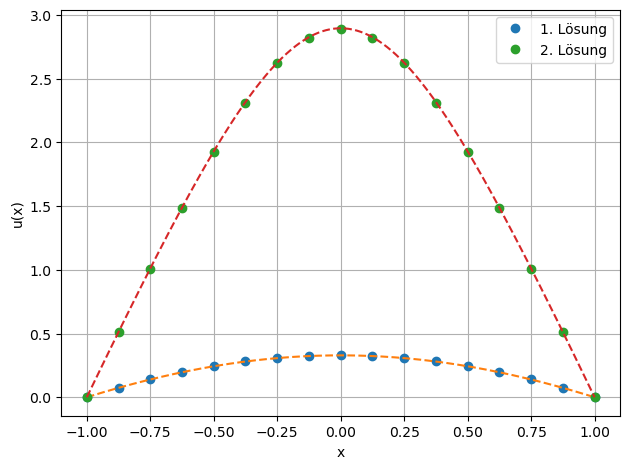

In [15]:
plt.plot(x,u1,'o',label='1. Lösung')
plt.plot(xp,uanalytical(xp,0.5,1),'--')
plt.plot(x,u,'o',label='2. Lösung')
plt.plot(xp,uanalytical(xp,0.5,10),'--')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('u(x)')
plt.tight_layout()
#plt.savefig('gelfandNewtonLoesung.pdf')
plt.show()

## Vereinfachtes Newton-Verfahren

In [16]:
n = 2**4
x = np.linspace(-a,a,n+1)
h = 2*a/n
# Initialisieren
u = 3*np.cos(x*np.pi/2)
res2 = [norm(g(u,lam,h))]
k = 0
N = 15
tol = 1e-14
# Newton Iteration
# einmal Jacobi-Matrix berechnen
A = dg(u,lam,h)
q,r = qr(A)

while k < N and res2[-1] > tol:
    b = g(u,lam,h)
    delta = solve_triangular(r,q.T@b)
    u[1:-1] -= delta
    res2.append(norm(g(u,lam,h)))
    k += 1

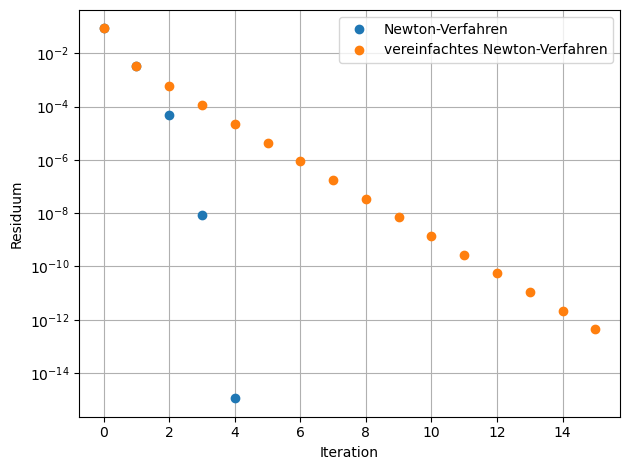

In [17]:
plt.semilogy(res, 'o', label='Newton-Verfahren')
plt.semilogy(res2, 'o', label='vereinfachtes Newton-Verfahren')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Residuum')
plt.tight_layout()
plt.savefig('gelfandKonvergenzNewton.pdf')
plt.show()